# Learning to create a Dataset, Dataloader and train a model

## 1. Downloading the data

In [1]:
!wget -O pneumonia.zip 'https://storage.googleapis.com/kaggle-data-sets/519943/964544/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1582811969&Signature=DKN5ndoVIjwRt54KXl%2B20tgt6s2oyRT4fqzkmwOKiiBOu8VqI1fi8XGsSmTd0xaSxIszgngbQrTtu%2FZW4fyM9VZfqOvtduFSUkIDCYbCLZj4XJEe7NIcFnD9EC8FE4EkAMowtdkT%2BiGza44yDASeka0mBQEy65OVw1WJTQU%2BZQyjjZ82xiL5f5ETdaIdZaGuszQ2p7R7DGyuync6e58ac4fkh281xx6OVqYzXcs6%2FMaHkA%2FoLzUJ7O4Nvz15zS1UoE09ATDhBL412kn9gL36vDMN3j5CfGAB1qePf8%2Bi1G323bQH9T8rJZtUi%2BQQx0tRqtnZmZD0jnD2KcYtwWXsag%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-images-for-classification-pneumonia.zip'

--2020-02-24 14:02:06--  https://storage.googleapis.com/kaggle-data-sets/519943/964544/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1582811969&Signature=DKN5ndoVIjwRt54KXl%2B20tgt6s2oyRT4fqzkmwOKiiBOu8VqI1fi8XGsSmTd0xaSxIszgngbQrTtu%2FZW4fyM9VZfqOvtduFSUkIDCYbCLZj4XJEe7NIcFnD9EC8FE4EkAMowtdkT%2BiGza44yDASeka0mBQEy65OVw1WJTQU%2BZQyjjZ82xiL5f5ETdaIdZaGuszQ2p7R7DGyuync6e58ac4fkh281xx6OVqYzXcs6%2FMaHkA%2FoLzUJ7O4Nvz15zS1UoE09ATDhBL412kn9gL36vDMN3j5CfGAB1qePf8%2Bi1G323bQH9T8rJZtUi%2BQQx0tRqtnZmZD0jnD2KcYtwWXsag%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-images-for-classification-pneumonia.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451790510 (2.3G) [application/zip]
Saving to: ‘pneumonia.zip’

pneumonia.zip   

In [0]:
!unzip pneumonia.zip

In [4]:
!ls

pneumonia  pneumonia2  pneumonia.zip  sample_data


## 2. Creating the dataset and dataloader

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalizdle([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
!ls pneumonia

test  train  validation


In [0]:
ds = {'train': datasets.ImageFolder('pneumonia/train',data_transforms['train']),
      'valid': datasets.ImageFolder('pneumonia/validation', data_transforms['val'])}

In [0]:
dl = {'train': torch.utils.data.DataLoader(ds['train'],batch_size=16,shuffle=True,num_workers=2),
      'valid': torch.utils.data.DataLoader(ds['valid'],batch_size=16,shuffle=True,num_workers=2)}

In [0]:
dataset_sizes = {x: len(ds[x]) for x in ['train', 'valid']}
class_names = ds['train'].classes

In [0]:
def show_batch(dataloader,size = 8):

    inputs, classes = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    #inputs = inputs.astype('uint8')
    w,h = size, size
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 2
    ax=[]
    for i in range(1, columns*rows +1):
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title('Class: '+str(classes[i].item()))
        plt.imshow((inputs[i]*255).astype(np.uint8))
    plt.show()

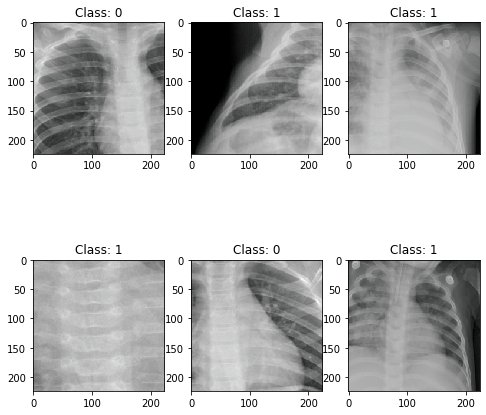

In [11]:
show_batch(dl['train'])

## 3. Creating and training a Model

In [0]:
mdl = models.resnet50(pretrained=True)

In [0]:
mdl.fc = nn.Linear(2048,2)

In [0]:
#making sure I'm using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
mdl = mdl.to(device)

#making sure I'm not updating the weights for the conv layers
#for param in mdl.parameters():
#    param.requires_grad = False

criterion = nn.CrossEntropyLoss()

# Training only the fully connected layer
optimizer_ft = optim.SGD(mdl.fc.parameters(), lr=1e-4, momentum=0.9)

In [0]:
#using cyclic LRs and Momentuns
scheduler = lr_scheduler.CyclicLR(optimizer_ft,base_lr=1e-5,max_lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
#defining the training function
def fit_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #loss.requires_grad = True

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [76]:
mdl_fitted = fit_model(mdl, criterion, optimizer_ft, scheduler ,num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5953 Acc: 0.7051
valid Loss: 0.5506 Acc: 0.7295

Epoch 1/99
----------
train Loss: 0.5482 Acc: 0.7299
valid Loss: 0.5080 Acc: 0.7304

Epoch 2/99
----------
train Loss: 0.5232 Acc: 0.7307
valid Loss: 0.4769 Acc: 0.7363

Epoch 3/99
----------
train Loss: 0.4978 Acc: 0.7418
valid Loss: 0.4534 Acc: 0.7807

Epoch 4/99
----------
train Loss: 0.4825 Acc: 0.7566
valid Loss: 0.4265 Acc: 0.8200

Epoch 5/99
----------
train Loss: 0.4693 Acc: 0.7632
valid Loss: 0.4066 Acc: 0.8311

Epoch 6/99
----------
train Loss: 0.4518 Acc: 0.7879
valid Loss: 0.3931 Acc: 0.8720

Epoch 7/99
----------
train Loss: 0.4444 Acc: 0.7925
valid Loss: 0.3787 Acc: 0.8780

Epoch 8/99
----------
train Loss: 0.4313 Acc: 0.8042
valid Loss: 0.3727 Acc: 0.8780

Epoch 9/99
----------
train Loss: 0.4230 Acc: 0.8093
valid Loss: 0.3570 Acc: 0.8814

Epoch 10/99
----------
train Loss: 0.4142 Acc: 0.8118
valid Loss: 0.3490 Acc: 0.8874

Epoch 11/99
----------
train Loss: 0.4053 Acc: 0.8170
valid Loss